# ``UNet`` demo

To use this demo, build the conda env defined in ``requirements-dev.conda.yaml``.


## The dataset: PanNuke—Nuclei detection

The data are availble [here](https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke).

Original publication:
- [PanNuke: An Open Pan-Cancer Histology Dataset for Nuclei Instance Segmentation and Classification](https://link.springer.com/chapter/10.1007/978-3-030-23937-4_2)

Extension publication:
- [PanNuke Dataset Extension, Insights and Baselines](https://arxiv.org/abs/2003.10778).


Before we can even look at the PanNuke data, we need to understand how it is presented: the data have been split into three cross-validation folds. For each fold, we are given images and segmentation masks, stacked together in numpy arrays.

To simplify things, we can open save the individual patches to file.

In [1]:
from pathlib import Path
from pandas import DataFrame

from skimage.io import imsave
from numpy import load, uint8


base_dir = Path("/home/jim/storage/PanNuke/")
patch_dir = base_dir.with_name("pan-nuke-patches")

images = list(base_dir.glob("*/*/images/*/images.npy"))
types = list(map(lambda x: Path(str(x).replace("images.npy", "types.npy")), images))
masks = list(map(lambda x: Path(str(x).replace("images", "masks")), images))


big_data = DataFrame(
    columns=["images", "types", "masks"], data=zip(images, types, masks)
)

Now that we have the file paths and metadata for the large data files, the next step is to save the individual image patches.

In [2]:
big_data["fold"] = big_data.images.apply(lambda x: x.parent.name)

big_data = big_data.sort_values(by="fold")


for row in big_data.itertuples():
    if patch_dir.exists():
        break

    images = load(row.images).astype(uint8)
    masks = load(row.masks).astype(uint8)
    types = load(row.types)

    for idx, (img, mask, tissue_type) in enumerate(zip(images, masks, types)):
        img_path = patch_dir / f"{row.fold}/images/{tissue_type}/{idx}.png"
        img_path.parent.mkdir(exist_ok=True, parents=True)

        imsave(img_path, img, check_contrast=False)

        mask_path = patch_dir / f"{row.fold}/masks/{tissue_type}/{idx}.png"
        mask_path.parent.mkdir(exist_ok=True, parents=True)

        imsave(
            mask_path,
            mask.argmax(axis=2).astype(uint8),
            check_contrast=False,
        )

Now we can create a dataframe holding the metadata for each of the individual images.

In [3]:
from torch_tools.file_utils import traverse_directory_tree

patch_data = DataFrame()

files = traverse_directory_tree(patch_dir)

patch_data["image"] = list(filter(lambda x: "images" in str(x), files))
patch_data["mask_img"] = patch_data.image.apply(
    lambda x: Path(str(x).replace("images", "masks"))
)

patch_data["file_name"] = patch_data.image.apply(lambda x: x.name)


patch_data["fold"] = patch_data["image"].apply(lambda x: x.parent.parent.parent.name)
patch_data["tissue_type"] = patch_data["image"].apply(lambda x: x.parent.name)

Now that we have the metadata for all of the images, in one place, we can split them into training and validation sets.

In [4]:
train_data = patch_data.loc[patch_data.fold != "fold3"].reset_index(drop=True)
valid_data = patch_data.loc[patch_data.fold == "fold3"].reset_index(drop=True)

train_data = train_data.sort_values(by=["fold", "tissue_type", "file_name"])
valid_data = valid_data.sort_values(by=["fold", "tissue_type", "file_name"])

valid_data = valid_data.sample(frac=1.0, random_state=123)

print(train_data.tissue_type.value_counts())
print(valid_data.tissue_type.value_counts())

tissue_type
Breast           1576
Colon             946
Esophagus         283
Adrenal_gland     282
Bile-duct         262
HeadNeck          239
Cervix            207
Pancreatic        167
Thyroid           164
Skin              146
Testis            139
Lung              133
Liver             131
Prostate          114
Stomach            98
Ovarian            94
Kidney             93
Bladder            82
Uterus             23
Name: count, dtype: int64
tissue_type
Breast           775
Colon            494
Uterus           163
Bile-duct        158
Adrenal_gland    155
HeadNeck         145
Esophagus        141
Liver             93
Cervix            86
Prostate          68
Bladder           64
Thyroid           62
Testis            57
Ovarian           52
Lung              51
Stomach           48
Kidney            41
Skin              41
Pancreatic        28
Name: count, dtype: int64


In [5]:
from skimage.io import imread

from torchvision.transforms import ToTensor, Compose
from torchvision.transforms import ColorJitter
from torchvision.transforms.functional import rotate

from torch import from_numpy, randint


from torch_tools import DataSet
from torch_tools.torch_utils import target_from_mask_img


def input_tfms(training: bool) -> Compose:
    """Create input transforms.

    Parameters
    ----------
    training : bool
        Are these training or validation transforms?

    Returns
    -------
    Compose
        A composition of transforms.

    """
    tfm_list = [imread, ToTensor()]

    if training is True:
        tfm_list.append(
            ColorJitter(brightness=0.05, contrast=0.05, hue=0.05, saturation=0.05)
        )

    return Compose(tfm_list)


def target_tfms(training: bool) -> Compose:
    """Create target transforms.

    Parameters
    ----------
    training : bool
        Are these training or validation transforms?

    Returns
    -------
    Compose
        A composition of transforms.

    """
    tfm_list = [
        imread,
        from_numpy,
        lambda x: (x != 5).int(),
        lambda x: target_from_mask_img(x, 2),
    ]

    if training is True:
        pass

    return Compose(tfm_list)


def both_tfms(training: bool) -> Compose:
    """Create transforms to be applied to both the image and targets.

    Parameters
    ----------
    training : bool
        Are these training or validation transforms?

    Returns
    -------
    Compose
        A composition of transforms.

    """
    tfm_list = []

    if training is True:
        tfm_list.append(lambda x: rotate(x, randint(4, (1,)).item() * 90.0))

    return Compose(tfm_list)


train_set = DataSet(
    train_data.image.to_list(),
    targets=train_data.mask_img.to_list(),
    input_tfms=input_tfms(True),
    target_tfms=target_tfms(True),
    both_tfms=both_tfms(True),
)


valid_set = DataSet(
    valid_data.image.to_list(),
    targets=valid_data.mask_img.to_list(),
    input_tfms=input_tfms(False),
    target_tfms=target_tfms(False),
    both_tfms=both_tfms(False),
)

## Create ``DataLoader``s

Now we turn the data sets into data loaders.

In [6]:
from torch.utils.data import DataLoader

bs = 9

train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)

valid_loader = DataLoader(valid_set, batch_size=bs, shuffle=False)

## Visualising a validation batch

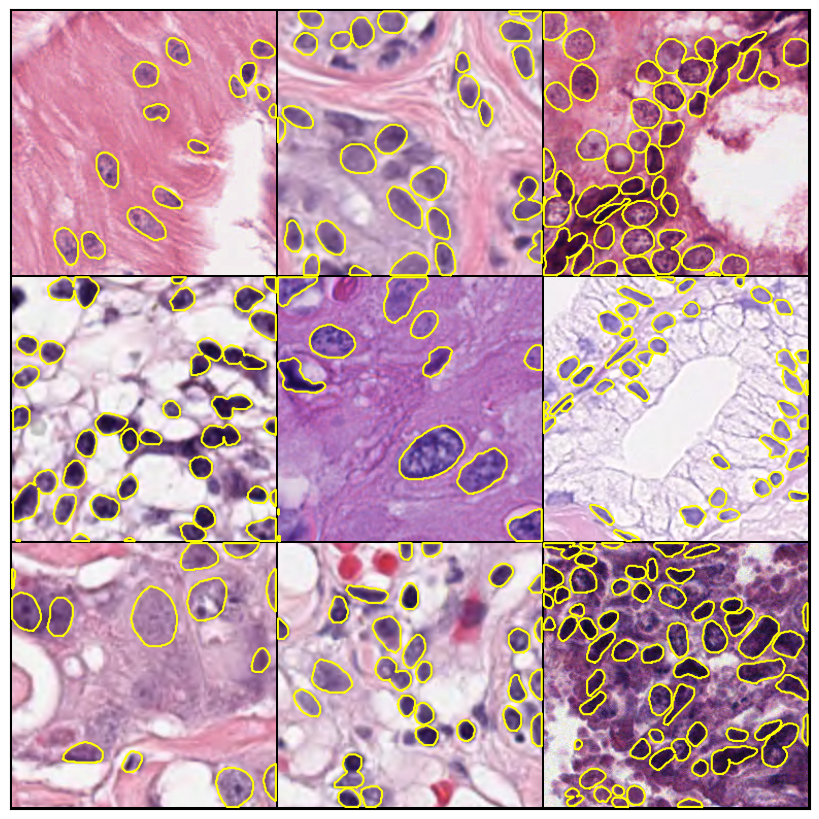

In [7]:
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

from skimage.measure import find_contours

from numpy import sqrt


for batch, targets in valid_loader:
    test_batch = batch[:]
    break

img_grid = make_grid(batch, nrow=int(sqrt(bs))).permute(1, 2, 0)
tgt_grid = make_grid(targets, nrow=int(sqrt(bs))).permute(1, 2, 0).argmax(dim=2).numpy()


figure, axis = plt.subplots(1, 1, figsize=(8, 8))

axis.imshow(img_grid)

axis.set_xticks([])
axis.set_yticks([])

for coords in find_contours(tgt_grid):
    axis.plot(coords[:, 1], coords[:, 0], "-", color="yellow")

figure.tight_layout(pad=0.01)

## Model and optimiser

Now, we create the model and an optimiser to fit it with.

In [8]:
from torch.cuda import is_available
from torch_tools import UNet

from torch.optim import Adam


DEVICE = "cuda" if is_available() else "cpu"
print(f"Device set to '{DEVICE}'.")

model = UNet(in_chans=3, out_chans=2, block_style="conv_res").to(DEVICE)

print(model)

optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

Device set to 'cuda'.
UNet(
  (in_conv): ConvResBlock(
    (0): ConvBlock(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): ResidualBlock(
      (first_conv): ConvBlock(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.0)
      )
      (second_conv): ConvBlock(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (2): Dropout2d(p=0.25, inplace=False)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

## Training/validation loop

In [9]:
from typing import Dict, Optional

from torch import set_grad_enabled, no_grad, Tensor
from torch.nn import Module

from torch.nn.functional import binary_cross_entropy

from numpy import nanmean, nan
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


@no_grad()
def get_metrics(preds: Tensor, targets: Tensor) -> Dict[str, float]:
    """Extract segmentation performance metrics."""
    preds = preds.argmax(dim=1).flatten().cpu()
    targets = targets.argmax(dim=1).flatten().cpu()

    metrics = {
        "precision": precision_score(targets, preds),
        "recall": recall_score(preds, targets),
        "dice": f1_score(preds, targets, zero_division=nan),
    }

    return metrics


def one_epoch(model: Module, loader: DataLoader, optim: Optional[Adam] = None):
    """Train or validate the model for a single epoch.

    Parameters
    ----------
    model : Module
        The model, to be fit.
    loader : DataLoader
        Training or validation loader.
    optim : Adam, optional
        The optimiser to fit the model with.

    Returns
    -------
    Dict[str, float]
        Metrics.

    """
    metrics = {
        "loss": [],
        "dice": [],
        "precision": [],
        "recall": [],
    }

    _ = model.train() if (optim is not None) else model.eval()

    for batch, targets in loader:
        if optim is not None:
            optim.zero_grad()

        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        with set_grad_enabled(optim is not None):
            preds = model(batch).softmax(dim=1)

        loss = binary_cross_entropy(preds, targets)

        if optim is not None:
            loss.backward()
            optim.step()

        metrics["loss"].append(loss.item())

        for key, val in get_metrics(preds, targets).items():
            metrics[key].append(val)

    if optim is not None:
        optim.zero_grad()

    return {key: nanmean(val) for key, val in metrics.items()}

In [10]:
from time import perf_counter

epochs = 20


from torch.optim.lr_scheduler import PolynomialLR
scheduler = PolynomialLR(optimizer=optimiser, total_iters=epochs, power=1)


train_list, valid_list = [], []

In [11]:
from numpy import floor
from time import sleep

for epoch in range(epochs):
    start = perf_counter()

    train_list.append(one_epoch(model, train_loader, optimiser))

    valid_list.append(one_epoch(model, valid_loader))

    scheduler.step()

    stop = perf_counter()

    mins = int(floor((stop - start) / 60.0))
    secs = (stop - start) % 60

    print(f"Epoch {epoch + 1} time: {mins} mins, {secs:.2f} seconds.")
    sleep(180)

Epoch 1 time: 6 mins, 3.60 seconds.
Epoch 2 time: 6 mins, 2.12 seconds.
Epoch 3 time: 6 mins, 8.44 seconds.
Epoch 4 time: 6 mins, 1.42 seconds.
Epoch 5 time: 6 mins, 2.10 seconds.
Epoch 6 time: 6 mins, 1.21 seconds.
Epoch 7 time: 6 mins, 0.28 seconds.
Epoch 8 time: 6 mins, 0.82 seconds.
Epoch 9 time: 5 mins, 48.89 seconds.
Epoch 10 time: 5 mins, 48.84 seconds.
Epoch 11 time: 6 mins, 2.14 seconds.
Epoch 12 time: 5 mins, 57.28 seconds.
Epoch 13 time: 5 mins, 56.94 seconds.
Epoch 14 time: 5 mins, 59.73 seconds.
Epoch 15 time: 6 mins, 6.06 seconds.
Epoch 16 time: 6 mins, 13.51 seconds.
Epoch 17 time: 5 mins, 58.12 seconds.
Epoch 18 time: 5 mins, 48.27 seconds.
Epoch 19 time: 5 mins, 59.05 seconds.
Epoch 20 time: 6 mins, 4.12 seconds.


    loss_train  dice_train  precision_train  recall_train  loss_valid  \
0     0.315200    0.650652         0.701175      0.701175    0.268108   
1     0.263080    0.696750         0.743805      0.743805    0.243537   
2     0.244923    0.720316         0.771031      0.771031    0.224413   
3     0.225389    0.743234         0.790163      0.790163    0.222722   
4     0.217605    0.754009         0.795429      0.795429    0.198213   
5     0.209480    0.762518         0.807279      0.807279    0.200977   
6     0.205270    0.769727         0.809649      0.809649    0.206117   
7     0.202751    0.770747         0.813198      0.813198    0.194451   
8     0.196959    0.778627         0.815168      0.815168    0.219977   
9     0.196642    0.781046         0.816877      0.816877    0.182146   
10    0.191141    0.784725         0.821045      0.821045    0.195034   
11    0.187000    0.789138         0.823246      0.823246    0.191297   
12    0.184996    0.790436         0.823538      0.

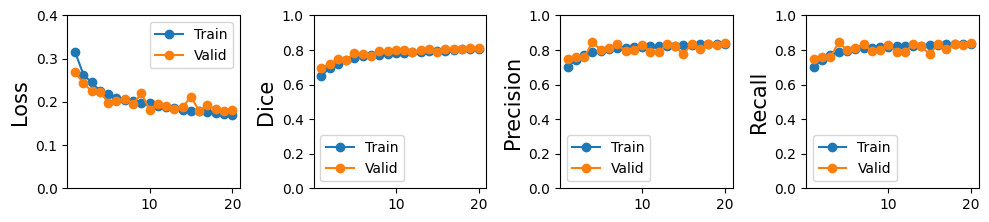

In [12]:
import matplotlib.pyplot as plt

from pandas import DataFrame

from numpy import diff, linspace

metrics = DataFrame(train_list).join(
    DataFrame(valid_list),
    lsuffix="_train",
    rsuffix="_valid",
)
print(metrics)


metric_names = ["loss", "dice", "precision", "recall"]
figure, axes = plt.subplots(
    1,
    len(metric_names),
    figsize=(2.5 * len(metric_names), 2.5),
)


x_vals = linspace(1, len(metrics), len(metrics))

for label, axis in zip(metric_names, axes.ravel()):
    for split in ["train", "valid"]:
        axis.plot(
            x_vals,
            metrics[f"{label}_{split}"],
            "-o",
            label=split.capitalize(),
        )


    axis.set_ylabel(label.capitalize(), fontsize=15)

    axis.legend(fontsize=10)

axes[0].set_ylim(bottom=0.0, top=0.4)

for axis in axes[1:].ravel():
    axis.set_ylim(bottom=0.0, top=1.0)

for axis in axes.ravel():
    axis.set_aspect(diff(axis.get_xlim()) / diff(axis.get_ylim()))



figure.tight_layout()

## Visualising some predictions

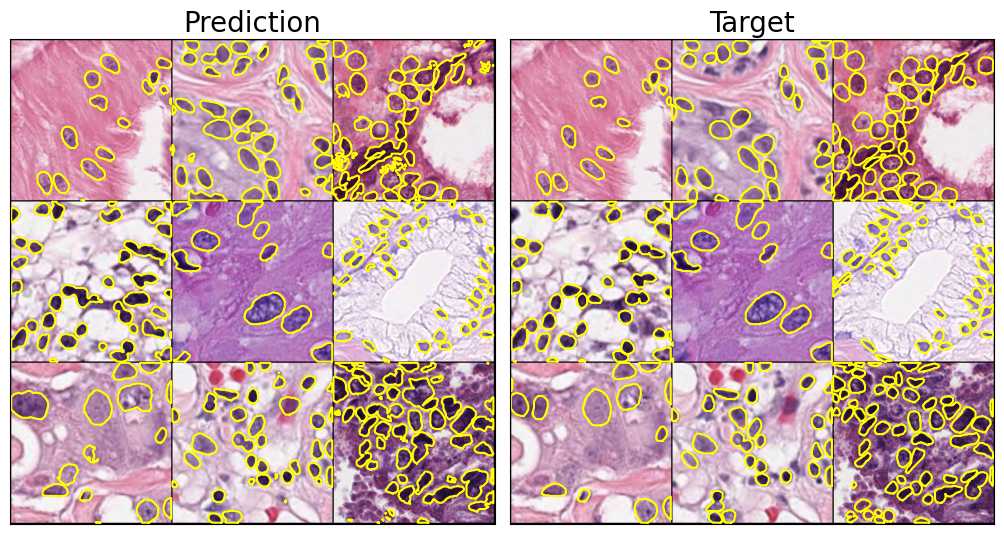

In [13]:
model.eval()


with no_grad():
    preds = model(test_batch.to(DEVICE)).softmax(dim=1).cpu()

image_grid = make_grid(batch, nrow=int(sqrt(bs))).permute(1, 2, 0)
pred_grid = make_grid(preds, nrow=int(sqrt(bs))).argmax(dim=0).numpy()
target_grid = make_grid(targets, nrow=int(sqrt(bs))).argmax(dim=0).numpy()


figure, axes = plt.subplots(1, 2, figsize=(10, 5))


for axis, tgt in zip(axes.ravel(), [pred_grid, target_grid]):
    axis.imshow(image_grid)

    for coords in find_contours(tgt):
        axis.plot(coords[:, 1], coords[:, 0], "-", color="yellow")

    axis.set_xticks([])
    axis.set_yticks([])


for axis, label in zip(axes.ravel(), ["Prediction", "Target"]):
    axis.set_title(label, fontsize=20)


figure.tight_layout(pad=0.05)